https://arxiv.org/pdf/2006.02382.pdf

the core model

In [1]:
def smooth_broken_power_law_model(t, freq, *theta):
    beta, F_p, t_p, s, alpha1, alpha2 = theta
    part1 = (2**(1/s))
    part2 = ((freq/(3e9))**beta)
    part3 = F_p
    part4 =  (t/t_p)**(-s*alpha1)
    part5 =  (t/t_p)**(-s*alpha2)
    
    ans =  part1*part2*part3*(part4+part5)**(-1/s)

    return ans

----------------------------------------------------------------------------------------------------------------------

In [2]:
from astropy.io import ascii
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import emcee

----------------------------------------------------------------------------------------------------------------------

data preparation. removing NaN and 0 error

In [3]:
data = ascii.read('gw170817_afterglow_data_full.txt')
data = data.to_pandas()

data["FluxD"] = data["FluxD"].apply(lambda x : float(x.lstrip("<")))

default_error = 0.05
data["FluxDErr"].fillna(data["FluxD"] * default_error, inplace = True)

#data["FluxDErr"] += default_error*data["FluxD"]
data["FluxDErr"] = np.where(data["FluxDErr"] == 0 , data["FluxD"] * default_error, data["FluxDErr"] )

In [4]:
data

,DateUT,T,Telescope,Freq,FluxD,FluxDErr
0,2017-Aug-18.10,0.57,VLA,9.700000e+09,144.00000,7.200000
1,2017-Aug-18.1,0.60,Swift,2.410000e+17,0.00780,0.000390
2,2017-Aug-18.21,0.68,ATCA,8.500000e+09,120.00000,6.000000
3,2017-Aug-18.21,0.68,ATCA,1.050000e+10,150.00000,7.500000
4,2017-Aug-18.2,0.70,NuSTAR,1.200000e+18,0.00073,0.000036
...,...,...,...,...,...,...
210,2021-Apr-08,1330.00,ATCA,5.500000e+09,44.00000,2.200000
211,2021-Apr-08,1330.00,ATCA,9.000000e+09,31.00000,1.550000
212,2020-Dec-09--2021-Jan-27,1231.00,Chandra,2.410000e+17,0.00017,0.000047
213,2020-Sep-19--2021-Feb-08,1228.00,VLA,3.000000e+09,2.86000,0.990000


In [5]:
data2 = data.loc[((data["Telescope"]=="VLA") & (data["Freq"]==3.0e9)) & (data["T"] > 4)| (data["Telescope"]=="Chandra")] 
#data2 = data

vla3ghzdata = data2.loc[(data2["Telescope"]=="VLA") & (data2["Freq"]==3.0e9)] 
chandradata = data2.loc[(data2["Telescope"]=="Chandra")]

mydata = (np.array(data2["T"]), np.array(data2["Freq"]), np.array(data2["FluxD"]), np.array(data2["FluxDErr"]))

In [6]:
(np.sort(data2["Freq"].unique()))


array([3.00e+09, 2.41e+17])

In [7]:
data2

,DateUT,T,Telescope,Freq,FluxD,FluxDErr
14,2017-Aug-19.9,2.4,Chandra,2.410000e+17,0.000230,0.000012
43,2017-Aug-26.7,9.2,Chandra,2.410000e+17,0.000448,0.000131
59,2017-Sep-01.4,14.9,Chandra,2.410000e+17,0.000511,0.000096
65,2017-Sep-2.9,16.4,VLA,3.000000e+09,18.700000,6.300000
67,2017-Sep-3.9,17.4,VLA,3.000000e+09,15.100000,3.900000
71,2017-Sep-4.9,18.3,VLA,3.000000e+09,14.500000,3.700000
82,2017-Sep-8.9,22.4,VLA,3.000000e+09,22.500000,3.400000
87,2017-Sep-10.8,24.2,VLA,3.000000e+09,25.600000,2.900000
92,2017-Sep-17.8,31.3,VLA,3.000000e+09,34.000000,3.600000
100,2017-Oct-2.8,46.3,VLA,3.000000e+09,44.000000,4.000000


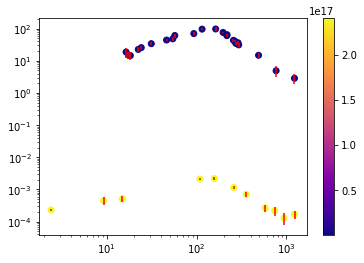

In [8]:
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

plt.scatter((mydata[0]),(mydata[2]), c = np.log(mydata[1]), cmap = "plasma")
plt.errorbar((mydata[0]),(mydata[2]), mydata[3], linestyle = '', c = "red")
plt.colorbar()
plt.show()

----------------------------------------------------------------------------------------------------------------

Explanation for this is in previous jupyter notebook

In [9]:
VLAfreq = 3.0e9 
Chandrafreq = 2.41e+17

beta = 4.6/np.log10(VLAfreq/Chandrafreq)
print(beta)   #ooh this matches pretty much exactly with the task in week1
F_p = 100
t_p = 100
s = 2
alpha1 = 1
alpha2 = -2

-0.5819178548902912


In [10]:
initial = np.array([beta, F_p, t_p, s, alpha1, alpha2])
ndim = len(initial)

def lnprior(theta):
    beta, F_p, t_p, s, alpha1, alpha2 = theta
    lis = [True]*6
    lis[0] = -1<beta<0 
    lis[1] = 200>F_p>50
    lis[2] = 200>t_p>50
    lis[3] = 10>s>0.1
    lis[4] = 2>=alpha1>=0
    lis[5] = -3<=alpha2<=-1
    if(False not in lis):
        return 0.0;
    return -np.inf

----------------------------------------------------------------------------------------------------------------

In [11]:
def main(p0, nwalkers, niter, ndim, lnprob, data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = data)

    print("Running burn in ")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()
    
    #the actual mcmc
    print("Running production")
    pos, prob, state = sampler.run_mcmc(p0, niter)
    return sampler, pos, prob, state

----------------------------------------------------------------------------------------------------------------

In [12]:
def sbplm(t, freq, *theta):
    return smooth_broken_power_law_model(t, freq, *theta)

In [13]:
def model(theta, t, freq):
    return sbplm(t, freq, *theta)

In [14]:
def lnlike(theta, t, freq, flux, flux_err):
    return -0.5 * np.sum(((flux-model(theta, t, freq))/flux_err)**2)


In [15]:
def lnprob(theta, t, freq, flux, flux_err):
    lp = lnprior(theta)
    if np.isfinite(lp):
        return lp + lnlike(theta, t, freq, flux, flux_err)
    return -np.inf

----------------------------------------------------------------------------------------------------------------

Fitting

In [16]:
nwalkers = 128
niter = 5000
scale = 10**np.floor(np.log10(abs(initial) + 1e-1)  )
p0 = [(initial + 1e-3 * scale* np.random.randn(ndim))   for i in range(nwalkers) ]

In [17]:
sampler, pos, prob, state = main(p0, nwalkers, niter, ndim, lnprob, mydata);

Running burn in 


Running production


In [18]:
samples = sampler.flatchain
best = samples[np.argmax(sampler.flatlnprobability)]

In [53]:
def very_specific_plot(data, samples, best, color, name):
    ax = plt.gca()
    plt.scatter(data["T"], data["FluxD"], c = color, label = name + " data")
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.errorbar(data["T"], data["FluxD"], yerr = data["FluxDErr"], ecolor="red", linestyle = 'None')


    # for theta in samples[np.random.randint(len(samples), size = 100)]:
    #     plt.plot(data["T"], smooth_broken_power_law_model(data["T"],data["Freq"],*theta), color = 'r', alpha = 0.1)
        
    plt.plot(data["T"], smooth_broken_power_law_model(data["T"],data["Freq"],*best), color = 'g', alpha = 1, label = name + " fit")
    #line.set_label(name)

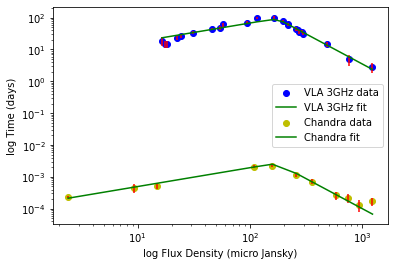

In [56]:
plt.xlabel("log Flux Density (micro Jansky)")
plt.ylabel("log Time (days)")



very_specific_plot(vla3ghzdata, samples, best, "b", "VLA 3GHz")
#plt.show()
very_specific_plot(chandradata, samples, best, "y", "Chandra")

plt.legend()

In [57]:
beta, F_p, t_p, s, alpha1, alpha2 = best.round(3)
print(f"beta {beta}, F_p {F_p}, t_p {t_p}, s {s}, alpha1 {alpha1}, alpha2 {alpha2}")

beta -0.575, F_p 85.622, t_p 174.096, s 7.609, alpha1 0.592, alpha2 -1.884


https://arxiv.org/pdf/2006.02382.pdf

pretty good but still different from the paper